# Data Cleaning 



In [239]:
#imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [240]:
#set options so entire dataframe is viewable
pd.options.display.max_columns = 10000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = None

In [241]:
# import posts from each subreddit 
onion_df = pd.read_csv('the_onion3.csv')
nto_df = pd.read_csv('not_the_onion.csv') 

In [242]:
# check shape of each dataset
onion_df.shape, nto_df.shape

((8486, 9), (9965, 9))

In [243]:
# total number of posts 
len(onion_df) + len(nto_df)

18451

## Moderator posts 

- Both subreddits being studied only allow posts pertaining to the topic of the respective subreddit. 
    - Therefore, we do not need to filter through the posts to see if any are off topic. 

- The only exception to the rules would be posts from moderators as they have the final say on which posts get to remain and which are moved to another subreddit. 
    - Possible deviations from the norm could be general annoucements or discussion posts. 
    
- Lets explore our samples from both subreddits to see if any posts from moderators should be removed for the purpose of our analysis.     

In [245]:
# make set with moderators from r/theonion  
#source: https://www.reddit.com/r/TheOnion/about/moderators/
onion_mods = {'xvvhiteboy'
'ParakeetNipple',
'TortoiseSex',
'RalphiesBoogers',
'pyrowolf8',
'Kijafa',
'T_Dumbsford','AutoModerator'}

#source: https://www.reddit.com/r/TheOnion/about/moderators/
# mods set for r/nottheonion 
nto_mods= {'Knowltey','x_minus_one','TAKEitTOrCIRCLEJERK','greenduch','Kezika','N8theGr8','NotTheOnionBot',
           'capecodcaper','BunnicusRex','greeniethemoose','AutoModerator'}

### r/theonion

In [173]:
# check if any mods posts in r/theonion  sample
set(onion_df['author'].unique()).intersection(onion_mods) 

{'RalphiesBoogers', 'TortoiseSex'}

In our sample of posts from r/theonion there are posts from two moderators. Lets explore those posts further to see if they should be removed. 

In [174]:
# look at posts by mods in r/theonion in our sample set
onion_df[(onion_df['author']=='TortoiseSex')|(onion_df['author']=='RalphiesBoogers')]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
4646,74 Normal Photos And 2 Kinda Weird Ones,NaN,the_onion,1503732302,RalphiesBoogers,0,4,False,2017-08-26
8300,Bedtime Story From Fucking Bible Again,NaN,the_onion,1404856297,TortoiseSex,0,8,False,2014-07-08


- Only two posts in our sample are from mods in r/theonion

- A quick search on reddit for those particular posts reveals that they follow the rules of the subreddit and thus should not be removed. 

Links to actual posts: 

https://www.reddit.com/r/TheOnion/comments/2a6kwl/bedtime_story_from_fucking_bible_again/

https://www.reddit.com/r/TheOnion/comments/6w4bc7/74_normal_photos_and_2_kinda_weird_ones/?utm_source=amp&utm_medium=&utm_content=post_title

###  r/nottheonion

In [246]:
# check if any mods posts in r/nottheonion sample
set(nto_df['author'].unique()).intersection(nto_mods)


{'N8theGr8'}

Our sample of posts from r/nottheonion only contains posts from one moderator. Lets explore those posts further to see if they should be removed.  

In [247]:
# posts from N8theGr8 in our sample from r/nottheonion
nto_df[nto_df['author']=='N8theGr8']

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
8672,N. Korean leader complains about weather service,NaN,not_the_onion,1402568083,N8theGr8,0,1,False,2014-06-12
8673,Bachelor party makes impressive fossil discovery in Elephant Butte,NaN,not_the_onion,1402568531,N8theGr8,1,32,False,2014-06-12
8764,'My house is on fire m8 lol' ... 911 texting tested in the US,NaN,not_the_onion,1400239375,N8theGr8,378,1473,False,2014-05-16


- Once again, a quick search on reddit shows that these posts follow the general rules of the subreddit. Therefore, we do not have reason to believe that they should be removed from our sample. 

Links to posts: 

https://www.reddit.com/r/nottheonion/comments/27ycg2/bachelor_party_makes_impressive_fossil_discovery/

https://www.reddit.com/r/nottheonion/comments/25pcwv/my_house_is_on_fire_m8_lol_911_texting_tested_in/



## Combine Samples


For modeling purposes posts from both subreddits will be combined into a single dataframe. In order to preserve the information regarding the origin of each post a column can be added with the name of the respective subreddit. 


In [244]:
#Add column for subreddit to each dataframe 
onion_df['subreddit'] = 'the_onion'
nto_df['subreddit'] = 'not_the_onion'


In [250]:
# combine dataframes 
posts= pd.concat([onion_df,nto_df],ignore_index=True)

In [251]:
#confirm results
len(posts)== len(onion_df)+ len(nto_df)

True

In [252]:
#confirm indexed properly 
posts.index

RangeIndex(start=0, stop=18451, step=1)

## Remove Duplicates 

- Since the posts in our sample were retrieved sequentially based on time of submission it is possible that multiple users posted links to the same article at different times and while gathering the data we picked up multiple entries for the same article. 

- Multiple observations with the same information will not provide any value for our purposes so we will drop any duplicates in our sample set.   



In [255]:
# drop duplicate entries for title 
posts = posts.drop_duplicates(subset=['title'],ignore_index=True)

In [16]:
# value counts 
posts['subreddit'].value_counts(normalize=True)

not_the_onion    0.55148
the_onion        0.44852
Name: subreddit, dtype: float64

In [185]:
len(posts)

17502

After dropping duplicates we have about 900 less observations in our sample set but the sample size is stil relatively large so this is not cause for concern. 

The balance of classes in our sample set is the same as before dropping duplicates so this indicates both subreddits had similar numbers of duplicates. 

## Remove Empty Posts 

As we are trying to build a classification model based on the text in the title, if a post does not have any text in the title then that post would not provide any value for our purposes. Therefore, we will remove any posts with no text in the title. 



In [284]:
# if length of string in title is not greater then 0 then drop that entry
posts = posts[posts['title'].apply(lambda x: len(x)) > 0]

In [289]:
# reset index for ease of use in future 
posts.reset_index(drop=True,inplace=True)

## Remove URLs 

- Both subreddits have the same general format for submissions. 
    - A headline followed by a link to an article. 
    
- Considering that r/theonion only allows posts from TheOnion all the links in posts from that subreddit will contain 'theonion.com' 

- When modeling, if the url to the article is not removed it would be trivial for any model to predict each submission with 100% accuracy based on whether it included a link to theonion.com or not
    - This would not be useful for our purposes as we are looking to be able to classify posts based on the headline and a trivial model would not generalize to other subreddits where misinformation may be coming from many different sources. 

- Therefore we will remove any URLS from the title of each post in our sample.  

Referenced: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python 

regex for urls: r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b'

In [258]:
# check how many urls in our sample set
posts['title'].str.contains(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',regex=True).sum()

<ipython-input-258-decabe1a5c31>:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  posts['title'].str.contains(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',regex=True).sum()


48

In [259]:
# remove urls
posts['title']= posts['title'].str.replace(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','',regex=True)

In [260]:
# confirm removed 
posts['title'].str.contains(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',regex=True).sum()

<ipython-input-260-bc25d48fbb52>:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  posts['title'].str.contains(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',regex=True).sum()


0

In addition to the URLs removed based on the above format, we can check if any urls that begin with just "www." are still present in our sample set. 

In [261]:
# check if 'www.' indicating start of url 
posts['title'].str.contains(r'[w]{3}\.').sum()

2

Two posts in our sample still have "www." in them 

In [266]:
# check posts with "www." 
posts[posts['title'].str.contains(r'[w]{3}\.')][['title']]

,title
3414,the home of www.dinar.tv
7742,I'm going to space camp! Yayyyyyaaawwwww...


- It is not clear from the url whether the first entry belongs to r/theonion or r/nottheonion so we will not remove it. 

- The second post does not actually contain a url so we will not make any modifications at this time. 

- Based on experience, often when people share URLs online they do not include the "http", "https", or even the "www." portion but something more like "example.com" 
    - Lets check to see if anything like this is present in our sample set  


In [269]:
# check for strings with .com 
posts['title'].str.contains(r'\.com').sum()

24

In [270]:
# remove urls with .com
posts['title']= posts['title'].str.replace(r'\.com','',regex=True)

In [271]:
#confirm replaced 
posts['title'].str.contains(r'\.com').sum()

0

We have removed URLS based on the most common formats for websites. It is possible for URLS with other formats to still be present in our dataset but we have removed the trivial cases. 



In [297]:
# Save Dataframe with progress 
posts.to_csv('./data/raw_posts.csv',index=False)

## Common reddit markdown 

- Text content on Reddit is stored in a Reddit specific version of markdown text.
    - It is used to to format text so it displays as intended. Examples: bold,italics, headings, superscipts etc.

- In 2018 Reddit changed its markdown formating and apperence from "old reddit" to "new reddit" in an effort to make the site more friendly for first time users [source](https://www.reddit.com/r/announcements/comments/7a4bjo/time_for_my_quarterly_inquisition_reddit_ceo_here/dp70sul/?context=2https://www.reddit.com/r/announcements/comments/7a4bjo/time_for_my_quarterly_inquisition_reddit_ceo_here/dp70sul/?context=2). 
    - Our sample set contains observations from both subreddits for before and after the transition. 
    - Since this is consistent in both subreddits this is initially not alarming but something to keep in mind. 
    - Due to the change in formatting if we were to try and make all the text in consistent format we would need to group the observations by the date of submission and use the appropriate markdown to format the text. This would add significant computational expenses. 
    
- Since users on both subreddits have the oppurtunity to format text (if they wish to do so) in the same format ,keeping time period consistant, it would be interesting to see if the markdown styling has an impact on our modeling.     

- Therefore, for the purpose of our analysis we will not remove any markdown text. If going this route does not lead to satisfactory results we can consider removing any markdown text for further studies. 


# Other Features 

Our goal is to build a model to classify posts as either being fake or real news using the headline or title of the submission on reddit. Therefore, for our initial study we will not add additional features or metadata about the posts so we can be confident that the results we are seeing are only based on the text itself and not other features. 

If after our current study, we find that it is possible to label text as either fake or real news depending on the text we can consider adding additional features to try and improve our model.  

In [84]:
# helper function
def significance_check(df,col):
    'non-parametric ANOVA test for numeric col for difference between subreddits in posts dataframe'
    return scipy.stats.kruskal(df[df['subreddit']=='the_onion'][col],
                   posts[df['subreddit']=='not_the_onion'][col],)

In [275]:
# helper function  
def group_diff(df,col):
    'returns basic stats for distribution of col, mean value per subreddit, graph by subreddit, and results from non-parametric ANOVA test '
    print(f'Overall Distribution of {col}')
    print(df[col].describe()) # overall distribution 
    print('\n')
    print(f"Mean {col} for both subreddits")
    print(pd.DataFrame(df.groupby('subreddit')[col].mean())) # mean per subreddit
    #graph distribution by subreddit
    sns.displot(x=df[col],hue=df['subreddit'],hue_order=['the_onion','not_the_onion'],kind='kde')
    plt.title(f'{col} by Subreddit')
    print('\n')
    return significance_check(posts,col) # ANOVA for statistical significance 

## Non-Alphanumeric Characters per Post

It is plausible that fake vs real news headlines might have different number of non-alphanumeric characters due to fake news headlines trying extra hard to grab readers attention. 



In [272]:
# function to get number of non-alphanumeric character for a given string 
def non_alphanum_count(string):
    'returns number of non-alphanumeric characters. excludes whitespaces'
    count=0
    for char in string: 
        if not (char.isalnum())|(char==' '): # ignoring white space as well 
            count +=1
    return count
            

In [273]:
#add column for non_alphanum_count 
posts['non_alphanum_count']= posts['title'].apply(non_alphanum_count)

Overall Distribution of non_alphanum_count
count    17502.000000
mean         1.633356
std          1.868089
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: non_alphanum_count, dtype: float64


Mean non_alphanum_count for both subreddits
               non_alphanum_count
subreddit                        
not_the_onion            1.646084
the_onion                1.617707




KruskalResult(statistic=0.416975462811989, pvalue=0.5184501006791598)

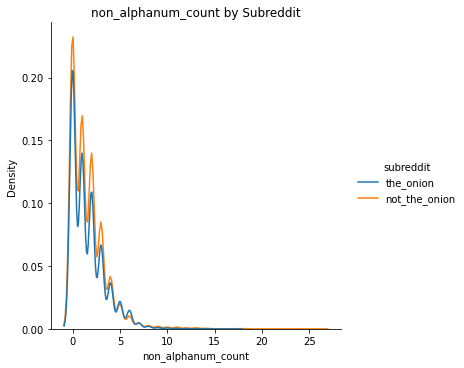

In [276]:
group_diff(posts,'non_alphanum_count')

- At least 75% of observations had at most 2 non-alphanumeric characters while the most was 25. 

- Both subreddits in question have a very similar number of non_alphanum_count and the difference is not significant. 

- It is not recommended to consider this feature for inclusion in future work. 

## Character Count

It would be interesting to see if titles in one subreddit were longer or shorter then those in the other subreddit. 

In [286]:
# make column for character count of each post 
posts['char_count']= posts['title'].apply(lambda x: len(x))

<ipython-input-286-9cb4d1f6b6b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts['char_count']= posts['title'].apply(lambda x: len(x))


Overall Distribution of char_count
count    17486.000000
mean        74.067940
std         30.264977
min          1.000000
25%         55.000000
50%         71.000000
75%         89.000000
max        299.000000
Name: char_count, dtype: float64


Mean char_count for both subreddits
               char_count
subreddit                
not_the_onion   70.193753
the_onion       78.823567




KruskalResult(statistic=423.70400471774605, pvalue=3.812713358399371e-94)

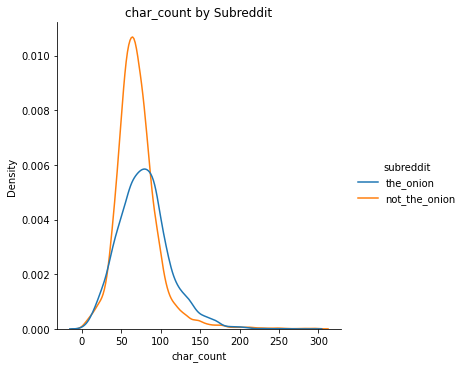

In [287]:
group_diff(posts,'char_count')

- On average posts in r/theonion were 8 characters longer then those in r/nottheonion
    - This might suggest that fake news article headlines tend to be longer overall. 


- The p-value of 0 suggests that given the two subreddits have the same number of characters per post there is a 0% likelyhood that a random sample would give us data as extreme as ours. At a 95% confidence level we can say that the difference in character count is statistically significant. 

- Therefore, this feature should be explored further in possible future studies. 



## Word Count 

We know that posts in r/theonion tend to have more characters in them but do they also have more words or just longer words? 

In [290]:
#make column for number of words in each post
posts['word_count']= posts['title'].apply(lambda x: len(x.split()))

Overall Distribution of word_count
count    17486.000000
mean        12.152122
std          5.241775
min          1.000000
25%          9.000000
50%         11.000000
75%         15.000000
max         56.000000
Name: word_count, dtype: float64


Mean word_count for both subreddits
               word_count
subreddit                
not_the_onion   11.481112
the_onion       12.975796




KruskalResult(statistic=344.2204539512421, pvalue=7.686829170406607e-77)

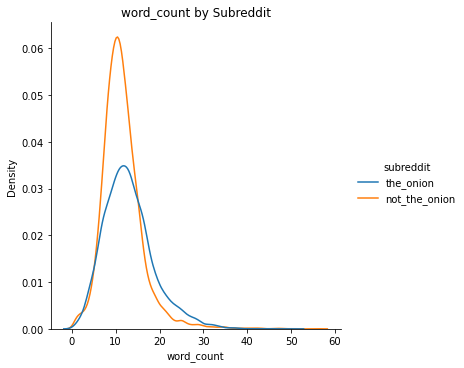

In [291]:
group_diff(posts,'word_count')

- On average, posts in r/theonion were 1.5 words longer then those in r/nottheonion. 

- Both subreddits had a similar shaped distribution with peaks around the mean and faily symmetric with the exception of the long tails to the right indicating the odd post that is much longer then the rest. 

- At a 95% confidence level, we can reject the null hypothesis that posts in both subreddits had the same median word count. Therefore, this difference is statistically significant so it should be considered for possible future studies. 

## Sentiment Analysis 

Do fake news articles tend to be more positive or negative then real news articles? 

In [292]:
# helper function
def senti_comps(string):
    'return composite polarity score of given string'
    return sia.polarity_scores(string)['compound']

In [293]:
# make column for composite sentiment score of each post
posts['senti_comp']= posts['title'].apply(senti_comps)

Overall Distribution of senti_comp
count    17486.000000
mean        -0.081717
std          0.401172
min         -0.965700
25%         -0.401900
50%          0.000000
75%          0.077200
max          0.969000
Name: senti_comp, dtype: float64


Mean senti_comp for both subreddits
               senti_comp
subreddit                
not_the_onion   -0.136165
the_onion       -0.014882




KruskalResult(statistic=360.83616903751, pvalue=1.8514463708984924e-80)

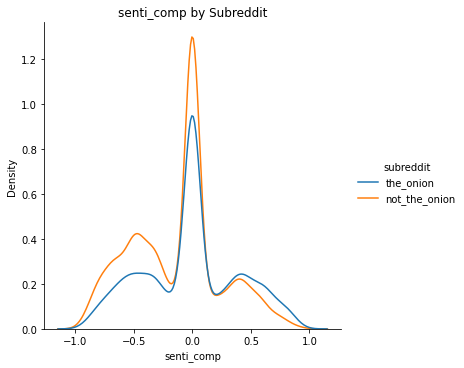

In [294]:
group_diff(posts,'senti_comp')

- Overall posts in both subreddits tended to be slightly more negative then positive. This is not surprising as most news articles are about bad things happening. 

- Titles from r/nottheonion had a slightly more negative sentiment. 
    - This is surprising because one might expect fake news articles to be more negative then the real world but in this case it seems the satirical nature of r/theonion might have made it more positive then real news. 
    
- Before adding this to any possible future predictive models it would be worthwhile to study if this trend holds in general or if this is a result of the intended satirical nature of r/theonion 